In [27]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

nltk.download('stopwords')
nltk.download('punkt')

# Charger les données
df = pd.read_csv("Restaurant reviews.csv")
df = df.drop(["Restaurant", "Reviewer", "Metadata", "Pictures", "7514"], axis=1)
df['Review'] = df['Review'].fillna("Nothing")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
df = df[pd.to_numeric(df['Rating'], errors='coerce').notnull()]
df['Rating'] = df['Rating'].astype(float)

# Transformation des notes en classes de 1 à 5
def label_sentiment(rating):
    if rating >= 4:
        return 5  # Avis très positif
    elif rating == 3:
        return 3  # Avis neutre
    elif rating <= 2:
        return 1  # Avis négatif
    else:
        return rating

df['target'] = df['Rating'].astype(float).apply(label_sentiment)


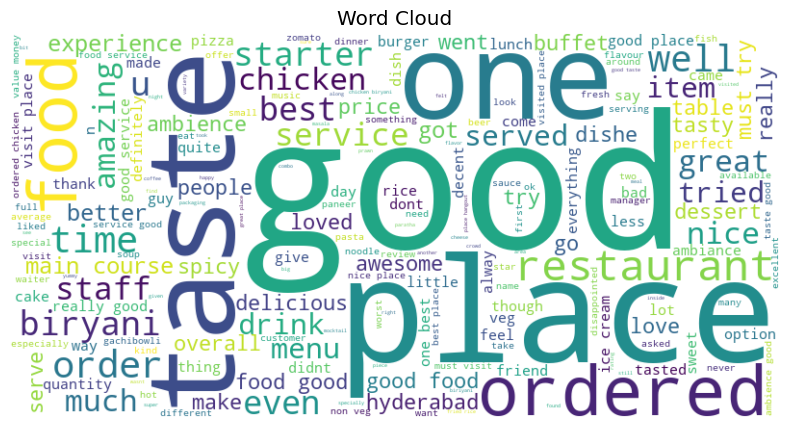

In [ ]:
# Nettoyage du texte
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['Processed_Review'] = df['Review'].apply(preprocess_text)

all_words = ' '.join(df['Processed_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [ ]:
# Charger les embeddings Word2Vec 
word2vec_path = 'GoogleNews-vectors-negative300.bin'  
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 300

In [ ]:
# Tokenisation
vocab_size = 5000  
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Processed_Review'])
sequences = tokenizer.texts_to_sequences(df['Processed_Review'])
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
y = df['target'].values - 1  

# Création de la matrice d'embedding Word2Vec
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        try:
            embedding_vector = word2vec[word]
            embedding_matrix[index] = embedding_vector
        except KeyError:
            pass 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Création du modèle pour prédire les classes de notes de 1 à 5
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)),
    GlobalMaxPool1D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(5, activation="softmax") 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.4967 - loss: 1.4239 - val_accuracy: 0.7772 - val_loss: 0.8997
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7453 - loss: 0.7006 - val_accuracy: 0.8078 - val_loss: 0.5784
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.7839 - loss: 0.5696 - val_accuracy: 0.8053 - val_loss: 0.4834
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8017 - loss: 0.5337 - val_accuracy: 0.8209 - val_loss: 0.4861
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8029 - loss: 0.5219 - val_accuracy: 0.8199 - val_loss: 0.4750
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8183 - loss: 0.4869 - val_accuracy: 0.8199 - val_loss: 0.4705
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8226 - loss: 0.4689 - val_accuracy: 0.8234 - val_loss: 0.4605
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.8273 - loss: 0.4385 - 

/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

Accuracy: 0.8304064224786754

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.75      0.84      0.79       482
           4       0.00      0.00      0.00         7
           5       0.55      0.24      0.34       233

   micro avg       0.72      0.64      0.68       722
   macro avg       0.26      0.22      0.23       722
weighted avg       0.68      0.64      0.64       722



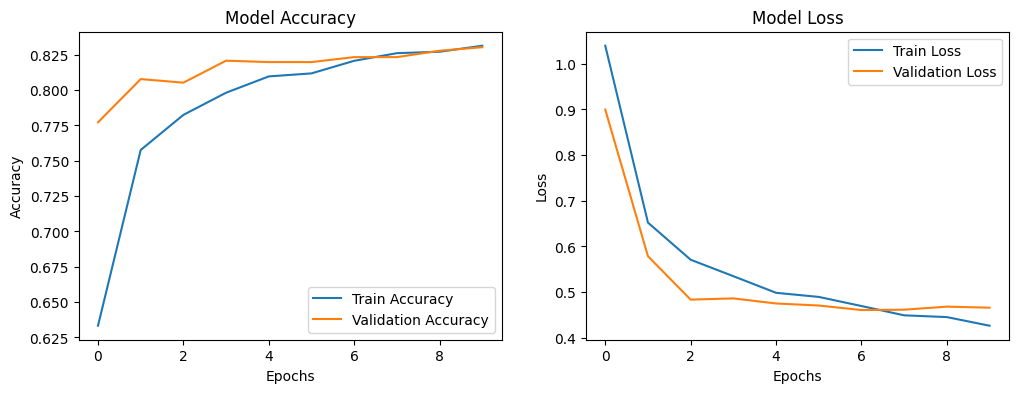

In [ ]:
# Corriger les labels pour qu'ils commencent à 1 au lieu de 0
y_test = y_test + 1
y_pred = y_pred + 1

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5], target_names=["1", "2", "3", "4", "5"])

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


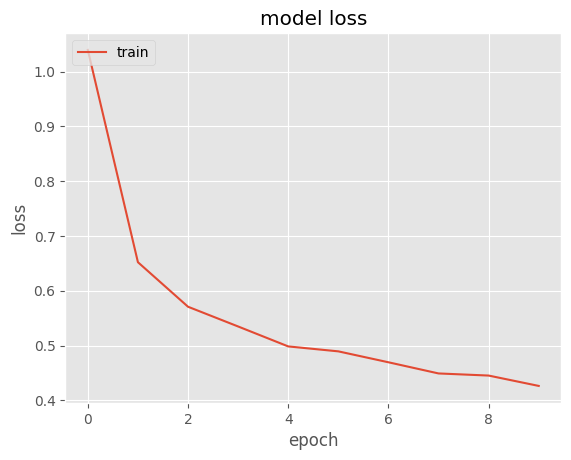

In [25]:
plt.style.use('ggplot')
%matplotlib inline

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
